In [7]:
from sklearn.datasets import load_boston
import os



import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
# boston = load_boston()

In [6]:
# print(boston.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


In [21]:
# print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

           0     1      2    3      4      5     6       7    8      9    10  \
0    0.00632  18.0   2.31  0.0  0.538  6.575  65.2  4.0900  1.0  296.0  15.3   
1    0.02731   0.0   7.07  0.0  0.469  6.421  78.9  4.9671  2.0  242.0  17.8   
2    0.02729   0.0   7.07  0.0  0.469  7.185  61.1  4.9671  2.0  242.0  17.8   
3    0.03237   0.0   2.18  0.0  0.458  6.998  45.8  6.0622  3.0  222.0  18.7   
4    0.06905   0.0   2.18  0.0  0.458  7.147  54.2  6.0622  3.0  222.0  18.7   
..       ...   ...    ...  ...    ...    ...   ...     ...  ...    ...   ...   
501  0.06263   0.0  11.93  0.0  0.573  6.593  69.1  2.4786  1.0  273.0  21.0   
502  0.04527   0.0  11.93  0.0  0.573  6.120  76.7  2.2875  1.0  273.0  21.0   
503  0.06076   0.0  11.93  0.0  0.573  6.976  91.0  2.1675  1.0  273.0  21.0   
504  0.10959   0.0  11.93  0.0  0.573  6.794  89.3  2.3889  1.0  273.0  21.0   
505  0.04741   0.0  11.93  0.0  0.573  6.030  80.8  2.5050  1.0  273.0  21.0   

         11    12  
0    396.90  4.98  

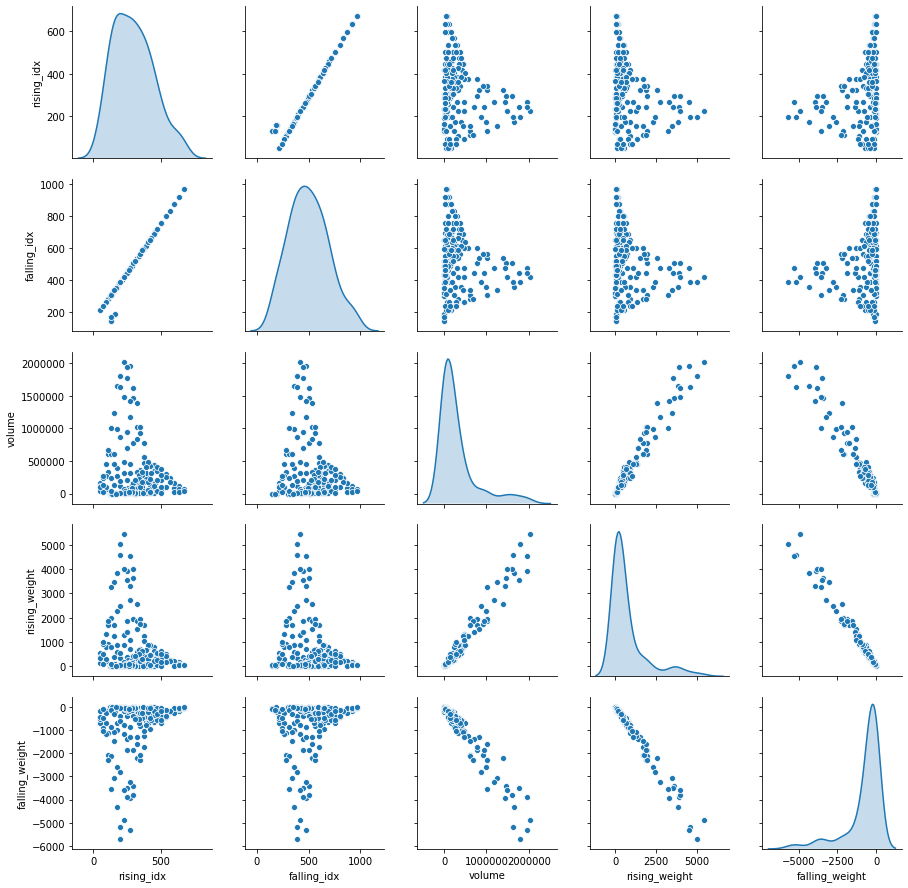

In [9]:
import pandas as pd



column_names = ['row','rising_idx','falling_idx','volume','rising_weight',
                'falling_weight', 'delay']

raw_dataset = pd.read_csv(os.getenv('DATA_FS') + '../preprocessing/processed.csv', names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True, usecols = column_names[1:])

dataset = raw_dataset.copy()
dataset.tail()

dataset = dataset.dropna()
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
sns.pairplot(train_dataset[["rising_idx", "falling_idx", "volume", "rising_weight", "falling_weight"]], diag_kind="kde")
train_stats = train_dataset.describe()
train_stats.pop("delay")
train_stats = train_stats.transpose()
train_stats
train_labels = train_dataset.pop('delay')
test_labels = test_dataset.pop('delay')


# data = pd.DataFrame(boston.data)
# data.columns = boston.feature_names

In [10]:
dataset.head()

,rising_idx,falling_idx,volume,rising_weight,falling_weight,delay
0,363,588,336106,629.522,-495.491,-1056.540
1,307,519,206278,422.998,-519.599,-689.914
2,335,554,281163,675.241,-675.555,-873.227
3,386,615,405526,664.439,-771.862,-1239.860
4,416,651,430377,882.944,-941.977,-1423.170


In [24]:
# data['PRICE'] = boston.target

In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218 entries, 0 to 217
Data columns (total 6 columns):
rising_idx        218 non-null int64
falling_idx       218 non-null int64
volume            218 non-null int64
rising_weight     218 non-null float64
falling_weight    218 non-null float64
delay             218 non-null float64
dtypes: float64(3), int64(3)
memory usage: 21.9 KB


In [12]:
dataset.describe

<bound method NDFrame.describe of      rising_idx  falling_idx  volume  rising_weight  falling_weight     delay
0           363          588  336106       629.5220       -495.4910 -1056.540
1           307          519  206278       422.9980       -519.5990  -689.914
2           335          554  281163       675.2410       -675.5550  -873.227
3           386          615  405526       664.4390       -771.8620 -1239.860
4           416          651  430377       882.9440       -941.9770 -1423.170
..          ...          ...     ...            ...             ...       ...
213         162          189      50        47.0800        -82.7965  1608.990
214         246          444  124004       237.5970       -233.1350  -224.157
215         458          702  162782       314.3220       -342.2130 -1690.680
216         404          638   50055        91.0816        -67.5744 -1324.060
217         157          341   12039        35.2498        -28.1037   509.093

[218 rows x 6 columns]>

In [13]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np


In [35]:
X, y = dataset.iloc[:,:-1],dataset.iloc[:,-1]

In [36]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [38]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [39]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

[16:10:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [40]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 890.809418


In [51]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 6, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=20,metrics="rmse", as_pandas=True, seed=123)

[16:12:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [52]:
cv_results.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
45,126.599152,11.330439,455.456991,35.827094
46,123.548396,11.995388,453.188121,35.392139
47,120.006915,12.511417,450.831522,37.783219
48,117.702161,11.991717,450.593007,37.348713
49,114.416807,10.052434,448.924113,35.087006


In [53]:
print((cv_results["test-rmse-mean"]).tail(1))

49    448.924113
Name: test-rmse-mean, dtype: float64


In [54]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[16:12:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


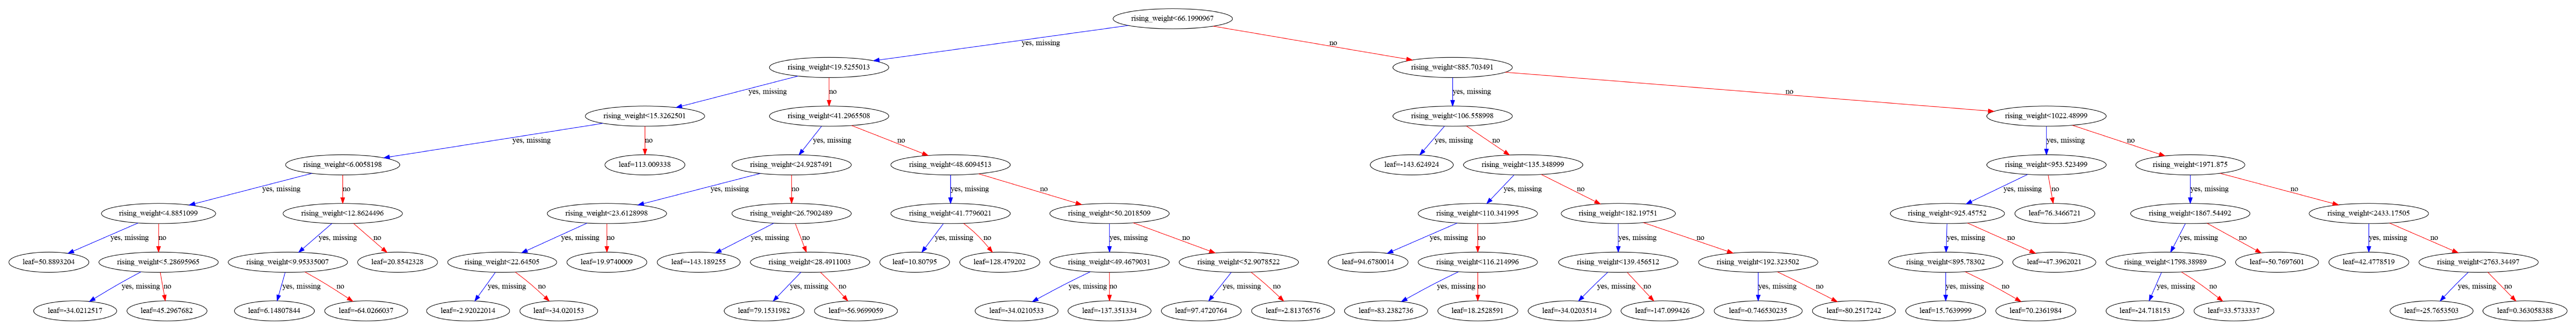

In [55]:
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 400

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

In [46]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [50,10]
plt.show()